# OLS Analysis Using Full PSU dataset

In [1]:
#Import required packages
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
def format_date(df_date):
    """
    Splits Meeting Times and Dates into datetime objects where applicable using regex.
    """
    df_date['Days'] = df_date['Meeting_Times'].str.extract('([^\s]+)', expand=True)
    df_date['Start_Date'] = df_date['Meeting_Dates'].str.extract('([^\s]+)', expand=True)
    df_date['Year'] = df_date['Term'].astype(str).str.slice(0,4)
    df_date['Quarter'] = df_date['Term'].astype(str).str.slice(4,6)
    df_date['Term_Date'] = pd.to_datetime(df_date['Year'] + df_date['Quarter'], format='%Y%m')
    df_date['End_Date'] = df_date['Meeting_Dates'].str.extract('(?<=-)(.*)(?= )', expand=True)
    df_date['Start_Time'] = df_date['Meeting_Times'].str.extract('(?<= )(.*)(?=-)', expand=True)
    df_date['Start_Time'] = pd.to_datetime(df_date['Start_Time'], format='%H%M')
    df_date['End_Time'] = df_date['Meeting_Times'].str.extract('((?<=-).*$)', expand=True)
    df_date['End_Time'] = pd.to_datetime(df_date['End_Time'], format='%H%M')
    df_date['Duration_Hr'] = ((df_date['End_Time'] - df_date['Start_Time']).dt.seconds)/3600
    return df_date

def format_xlist(df_xl):
    """
    revises % capacity calculations by using Max Enrollment instead of room capacity.  
    """
    df_xl['Cap_Diff'] = np.where(df_xl['Xlst'] != '', 
                                   df_xl['Max_Enrl'].astype(int) - df_xl['Actual_Enrl'].astype(int), 
                                   df_xl['Room_Capacity'].astype(int) - df_xl['Actual_Enrl'].astype(int)) 
    df_xl = df_xl.loc[df_xl['Room_Capacity'].astype(int) < 999]

    return df_xl   
    

## Partitioning a dataset in training and test sets

In [3]:
pd.set_option('display.max_rows', None)  


df = pd.read_csv('data/PSU_master_classroom_91-17.csv', dtype={'Schedule': object, 'Schedule Desc': object})
df = df.fillna('')

df = format_date(df)
# Avoid classes that only occur on a single day
df = df.loc[df['Start_Date'] != df['End_Date']]

#terms = [199104, 199204, 199304, 199404, 199504, 199604, 199704, 199804, 199904, 200004, 200104, 200204, 200304, 200404, 200504, 200604, 200704, 200804, 200904, 201004, 201104, 201204, 201304, 201404, 201504, 201604]
terms = [200604, 200704, 200804, 200904, 201004, 201104, 201204, 201304, 201404, 201504, 201604]
df = df.loc[df['Term'].isin(terms)]
df = df.loc[df['Online Instruct Method'] != 'Fully Online']

# Calculate number of days per week and treat Sunday condition
df['Days_Per_Week'] = df['Days'].str.len()
df['Room_Capacity'] = df['Room_Capacity'].apply(lambda x: x if (x != 'No Data Available') else 0)
df['Building'] = df['ROOM'].str.extract('([^\s]+)', expand=True)

df_cl = format_xlist(df)
df_cl['%_Empty'] = df_cl['Cap_Diff'].astype(float) / df_cl['Room_Capacity'].astype(float)

# Normalize the results
df_cl['%_Empty'] = df_cl['Actual_Enrl'].astype(np.float32)/df_cl['Room_Capacity'].astype(np.float32)
df_cl = df_cl.replace([np.inf, -np.inf], np.nan).dropna()


/home/kevin/anaconda3/envs/data-science/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kevin/anaconda3/envs/data-science/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
from sklearn.preprocessing import LabelEncoder

df_cl = df_cl.sample(n = 15000)

# Save as a 1D array. Otherwise will throw errors.
y = np.asarray(df_cl['%_Empty'], dtype="|S6")
df_cl = df_cl[['Dept', 'Class', 'Days', 'Start_Time', 'ROOM', 'Term', 'Room_Capacity', 'Building']]

cat_columns = ['Dept', 'Class', 'Days', 'Start_Time', 'ROOM', 'Building']

for column in cat_columns:
    room_mapping = {label: idx for idx, label in enumerate(np.unique(df_cl['{0}'.format(column)]))}
    df_cl['{0}'.format(column)] = df_cl['{0}'.format(column)].map(room_mapping)

from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version
    
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X = df_cl.iloc[:, 1:].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)


## Determine Feature Importances

 1) Class                          0.256130
 2) Term                           0.193341
 3) Start_Time                     0.171651
 4) ROOM                           0.130469
 5) Days                           0.119412
 6) Room_Capacity                  0.088591
 7) Building                       0.040407


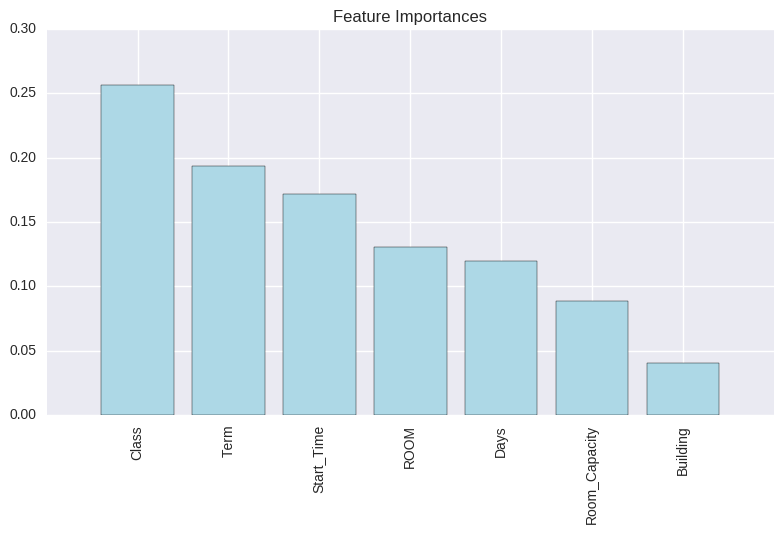

In [ ]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_cl.columns[1:]

forest = RandomForestClassifier(n_estimators=100,
                                random_state=0,
                                n_jobs=-1) # -1 sets n_jobs=n_CPU cores

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

Class, Term, and Start Times are the three most important factors in determining the percentage of empty seats expected.

# testing
#cols = ['Dept', 'Class', 'Days', 'Start_Time', 'ROOM', 'Term', 'Room_Capacity', 'Building']
testArr = X_train
#results = forest.predict(X_train)
X_train['predictions'] = results
X_train.head()

In [ ]:
# Random Forest Classification

from sklearn import model_selection

kfold = model_selection.KFold(n_splits=10, random_state=0)
model = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())